##### 2层卷积+2层分类，50k数据集训练

* train_data : shuffle 50k
* vali_data : 5k
* batch_size : 1000
* Optimizer : SGD
* learning_rate : 1e-5
* accuracy_threshold : 0.98
* step_limit : 64K

In [1]:
# start tensorflow interactiveSession           F1 = 0.711                 
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
vali_filename = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'
data = np.load(filename)
vali = np.load(vali_filename)
print('The shape of data is ',data.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.GradientDescentOptimizer(1e-5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
Eval = []

batch_size = 1000
for i in range(64000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    Loss.append(temp_loss)
    Eval.append(vali_accuracy)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %g" %(i, train_accuracy, temp_loss))
        if train_accuracy > 0.98:
            break


The shape of data is  (50989, 18449)
The shape of vali is  (5000, 18449)
step 0, train accuracy 0.064, train loss 10902.4
step 100, train accuracy 0.268, train loss 2868.05
step 200, train accuracy 0.342, train loss 2351.02
step 300, train accuracy 0.331, train loss 2147.67
step 400, train accuracy 0.4, train loss 1917.14
step 500, train accuracy 0.401, train loss 1897.01
step 600, train accuracy 0.407, train loss 1860.57
step 700, train accuracy 0.443, train loss 1734.8
step 800, train accuracy 0.465, train loss 1657.39
step 900, train accuracy 0.459, train loss 1613.5
step 1000, train accuracy 0.481, train loss 1640.03
step 1100, train accuracy 0.473, train loss 1636.3
step 1200, train accuracy 0.484, train loss 1587.56
step 1300, train accuracy 0.43, train loss 1616.25
step 1400, train accuracy 0.494, train loss 1520.83
step 1500, train accuracy 0.521, train loss 1513.54
step 1600, train accuracy 0.513, train loss 1486.84
step 1700, train accuracy 0.477, train loss 1506.23
step 1800

step 15600, train accuracy 0.676, train loss 954.325
step 15700, train accuracy 0.677, train loss 938.683
step 15800, train accuracy 0.665, train loss 945.227
step 15900, train accuracy 0.668, train loss 956.958
step 16000, train accuracy 0.683, train loss 936.14
step 16100, train accuracy 0.684, train loss 898.429
step 16200, train accuracy 0.704, train loss 857.726
step 16300, train accuracy 0.687, train loss 850.602
step 16400, train accuracy 0.697, train loss 891.982
step 16500, train accuracy 0.686, train loss 905.109
step 16600, train accuracy 0.708, train loss 866.976
step 16700, train accuracy 0.697, train loss 891.759
step 16800, train accuracy 0.704, train loss 877.802
step 16900, train accuracy 0.702, train loss 866.434
step 17000, train accuracy 0.686, train loss 887.57
step 17100, train accuracy 0.694, train loss 894.628
step 17200, train accuracy 0.689, train loss 875.747
step 17300, train accuracy 0.711, train loss 866.391
step 17400, train accuracy 0.709, train loss 861

step 31200, train accuracy 0.753, train loss 707.119
step 31300, train accuracy 0.752, train loss 718.478
step 31400, train accuracy 0.755, train loss 711.653
step 31500, train accuracy 0.757, train loss 679.311
step 31600, train accuracy 0.754, train loss 685.469
step 31700, train accuracy 0.765, train loss 675.99
step 31800, train accuracy 0.779, train loss 662.433
step 31900, train accuracy 0.769, train loss 686.487
step 32000, train accuracy 0.775, train loss 662.424
step 32100, train accuracy 0.735, train loss 774.924
step 32200, train accuracy 0.781, train loss 652.11
step 32300, train accuracy 0.765, train loss 698.79
step 32400, train accuracy 0.753, train loss 723.291
step 32500, train accuracy 0.773, train loss 658.731
step 32600, train accuracy 0.774, train loss 677.959
step 32700, train accuracy 0.755, train loss 761.534
step 32800, train accuracy 0.788, train loss 638.574
step 32900, train accuracy 0.759, train loss 675.5
step 33000, train accuracy 0.771, train loss 659.00

step 46800, train accuracy 0.804, train loss 565.03
step 46900, train accuracy 0.772, train loss 638.223
step 47000, train accuracy 0.813, train loss 567.713
step 47100, train accuracy 0.799, train loss 554.607
step 47200, train accuracy 0.813, train loss 559.093
step 47300, train accuracy 0.789, train loss 604.879
step 47400, train accuracy 0.769, train loss 617.619
step 47500, train accuracy 0.811, train loss 569.787
step 47600, train accuracy 0.781, train loss 604.604
step 47700, train accuracy 0.791, train loss 573.823
step 47800, train accuracy 0.834, train loss 514.003
step 47900, train accuracy 0.817, train loss 575.348
step 48000, train accuracy 0.802, train loss 603.96
step 48100, train accuracy 0.801, train loss 593.991
step 48200, train accuracy 0.839, train loss 495.221
step 48300, train accuracy 0.812, train loss 557.467
step 48400, train accuracy 0.825, train loss 523.106
step 48500, train accuracy 0.846, train loss 498.472
step 48600, train accuracy 0.811, train loss 571

step 62400, train accuracy 0.815, train loss 550.363
step 62500, train accuracy 0.841, train loss 478.101
step 62600, train accuracy 0.85, train loss 453.977
step 62700, train accuracy 0.826, train loss 493.472
step 62800, train accuracy 0.812, train loss 539.921
step 62900, train accuracy 0.849, train loss 480.717
step 63000, train accuracy 0.822, train loss 490.094
step 63100, train accuracy 0.804, train loss 556.762
step 63200, train accuracy 0.855, train loss 461.987
step 63300, train accuracy 0.821, train loss 513.046
step 63400, train accuracy 0.854, train loss 444.165
step 63500, train accuracy 0.847, train loss 440.328
step 63600, train accuracy 0.831, train loss 516.129
step 63700, train accuracy 0.841, train loss 477.856
step 63800, train accuracy 0.839, train loss 474.349
step 63900, train accuracy 0.834, train loss 495.378


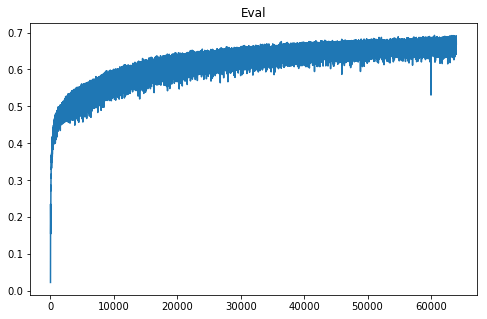

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,Eval)
plt.title('Eval')
plt.show()

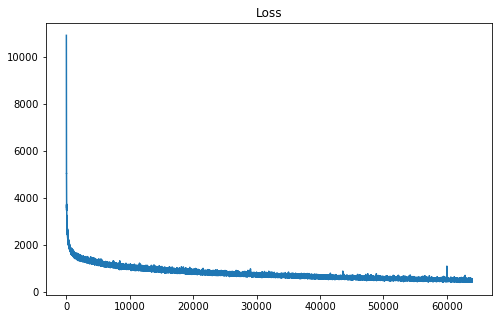

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.28      0.75      0.40        71
          1       0.67      0.56      0.61       342
          2       0.82      0.48      0.61       474
          3       0.40      0.75      0.53       119
          4       0.39      0.64      0.48       217
          5       0.67      0.54      0.60       487
          6       0.46      0.93      0.62        40
          7       0.88      0.51      0.65       586
          8       0.49      0.64      0.55       188
          9       0.34      0.49      0.40       158
         10       0.95      0.85      0.90       622
         11       0.27      0.82      0.41       125
         12       0.61      0.75      0.67       134
         13       0.85      0.50      0.63       585
         14       0.38      1.00      0.55        26
         15       0.60      0.96      0.73        91
         16       0.98      0.97      0.98       735

avg / total       0.75      0.67      0.68  

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('sixth_64k_batch_shuffle_balance_50k_train_SGD.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* train_data : shuffle 50k
* vali_data : 5k
* batch_size : 500
* Optimizer : SGD
* learning_rate : 1e-4
* accuracy_threshold : 0.98
* step_limit : 300K

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
vali_filename = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'
data = np.load(filename)
vali = np.load(vali_filename)
print('The shape of data is ',data.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
#Eval = []

batch_size = 500
for i in range(300000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
#    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    Loss.append(temp_loss)
#    Eval.append(vali_accuracy)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %g" %(i, train_accuracy, temp_loss))
        if train_accuracy > 0.98:
            break


The shape of data is  (50989, 18449)
The shape of vali is  (5000, 18449)
step 0, train accuracy 0.072, train loss 6248.11
step 100, train accuracy 0.236, train loss 1299.84
step 200, train accuracy 0.078, train loss 1375.32
step 300, train accuracy 0.19, train loss 1245.89
step 400, train accuracy 0.296, train loss 1114
step 500, train accuracy 0.278, train loss 1061.22
step 600, train accuracy 0.344, train loss 1003.64
step 700, train accuracy 0.38, train loss 989.333
step 800, train accuracy 0.352, train loss 961.495
step 900, train accuracy 0.374, train loss 914.666
step 1000, train accuracy 0.362, train loss 945.71
step 1100, train accuracy 0.412, train loss 875.967
step 1200, train accuracy 0.402, train loss 847.266
step 1300, train accuracy 0.408, train loss 876.163
step 1400, train accuracy 0.466, train loss 845.665
step 1500, train accuracy 0.45, train loss 823.215
step 1600, train accuracy 0.428, train loss 906.647
step 1700, train accuracy 0.404, train loss 849.885
step 1800,

step 15700, train accuracy 0.734, train loss 375.553
step 15800, train accuracy 0.766, train loss 354.943
step 15900, train accuracy 0.726, train loss 389.61
step 16000, train accuracy 0.764, train loss 384.788
step 16100, train accuracy 0.7, train loss 424.65
step 16200, train accuracy 0.702, train loss 420.181
step 16300, train accuracy 0.746, train loss 356.219
step 16400, train accuracy 0.754, train loss 368.572
step 16500, train accuracy 0.734, train loss 370.722
step 16600, train accuracy 0.746, train loss 364.51
step 16700, train accuracy 0.724, train loss 416.568
step 16800, train accuracy 0.778, train loss 350.549
step 16900, train accuracy 0.734, train loss 392.765
step 17000, train accuracy 0.752, train loss 388.88
step 17100, train accuracy 0.71, train loss 400.108
step 17200, train accuracy 0.702, train loss 416.091
step 17300, train accuracy 0.74, train loss 371.035
step 17400, train accuracy 0.756, train loss 362.604
step 17500, train accuracy 0.744, train loss 351.28
st

step 31300, train accuracy 0.806, train loss 262.934
step 31400, train accuracy 0.826, train loss 249.663
step 31500, train accuracy 0.798, train loss 289.721
step 31600, train accuracy 0.822, train loss 284.849
step 31700, train accuracy 0.822, train loss 252.327
step 31800, train accuracy 0.798, train loss 275.025
step 31900, train accuracy 0.814, train loss 276.92
step 32000, train accuracy 0.792, train loss 264.149
step 32100, train accuracy 0.786, train loss 272.149
step 32200, train accuracy 0.814, train loss 241.094
step 32300, train accuracy 0.826, train loss 241.294
step 32400, train accuracy 0.8, train loss 296.315
step 32500, train accuracy 0.832, train loss 245.898
step 32600, train accuracy 0.818, train loss 264.656
step 32700, train accuracy 0.792, train loss 294.787
step 32800, train accuracy 0.818, train loss 270.886
step 32900, train accuracy 0.802, train loss 287.584
step 33000, train accuracy 0.81, train loss 265.192
step 33100, train accuracy 0.836, train loss 236.9

step 46900, train accuracy 0.898, train loss 179.957
step 47000, train accuracy 0.852, train loss 217.257
step 47100, train accuracy 0.868, train loss 199.965
step 47200, train accuracy 0.852, train loss 203.909
step 47300, train accuracy 0.872, train loss 197.847
step 47400, train accuracy 0.88, train loss 189.642
step 47500, train accuracy 0.842, train loss 207.621
step 47600, train accuracy 0.884, train loss 167.746
step 47700, train accuracy 0.862, train loss 207.725
step 47800, train accuracy 0.858, train loss 201.764
step 47900, train accuracy 0.83, train loss 233.779
step 48000, train accuracy 0.868, train loss 203.542
step 48100, train accuracy 0.862, train loss 212.257
step 48200, train accuracy 0.876, train loss 192.861
step 48300, train accuracy 0.88, train loss 187.957
step 48400, train accuracy 0.838, train loss 235.021
step 48500, train accuracy 0.86, train loss 197.786
step 48600, train accuracy 0.878, train loss 200.138
step 48700, train accuracy 0.856, train loss 202.7

step 62500, train accuracy 0.896, train loss 133.829
step 62600, train accuracy 0.928, train loss 131.318
step 62700, train accuracy 0.904, train loss 140.176
step 62800, train accuracy 0.87, train loss 183.127
step 62900, train accuracy 0.886, train loss 151.287
step 63000, train accuracy 0.892, train loss 181.156
step 63100, train accuracy 0.9, train loss 151.837
step 63200, train accuracy 0.922, train loss 130.446
step 63300, train accuracy 0.898, train loss 150.232
step 63400, train accuracy 0.928, train loss 118.445
step 63500, train accuracy 0.908, train loss 174.713
step 63600, train accuracy 0.89, train loss 164.174
step 63700, train accuracy 0.904, train loss 159.902
step 63800, train accuracy 0.91, train loss 173.268
step 63900, train accuracy 0.872, train loss 181.654
step 64000, train accuracy 0.92, train loss 128.28
step 64100, train accuracy 0.918, train loss 136.29
step 64200, train accuracy 0.908, train loss 138.953
step 64300, train accuracy 0.912, train loss 133.628
s

step 78100, train accuracy 0.932, train loss 103.511
step 78200, train accuracy 0.918, train loss 123.106
step 78300, train accuracy 0.94, train loss 111.036
step 78400, train accuracy 0.926, train loss 123.112
step 78500, train accuracy 0.946, train loss 92.3723
step 78600, train accuracy 0.942, train loss 104.194
step 78700, train accuracy 0.944, train loss 99.5073
step 78800, train accuracy 0.934, train loss 115.593
step 78900, train accuracy 0.952, train loss 107.338
step 79000, train accuracy 0.948, train loss 91.2885
step 79100, train accuracy 0.924, train loss 130.424
step 79200, train accuracy 0.932, train loss 111.816
step 79300, train accuracy 0.934, train loss 115.441
step 79400, train accuracy 0.932, train loss 98.9997
step 79500, train accuracy 0.952, train loss 87.3668
step 79600, train accuracy 0.916, train loss 130.997
step 79700, train accuracy 0.948, train loss 96.1721
step 79800, train accuracy 0.938, train loss 115.567
step 79900, train accuracy 0.942, train loss 10

step 93700, train accuracy 0.978, train loss 50.352
step 93800, train accuracy 0.958, train loss 72.8953
step 93900, train accuracy 0.952, train loss 70.6434
step 94000, train accuracy 0.914, train loss 112.749
step 94100, train accuracy 0.966, train loss 69.451
step 94200, train accuracy 0.96, train loss 78.8697
step 94300, train accuracy 0.972, train loss 66.3173
step 94400, train accuracy 0.952, train loss 73.374
step 94500, train accuracy 0.96, train loss 73.1296
step 94600, train accuracy 0.95, train loss 89.1288
step 94700, train accuracy 0.956, train loss 73.5389
step 94800, train accuracy 0.942, train loss 77.2799
step 94900, train accuracy 0.956, train loss 90.9083
step 95000, train accuracy 0.96, train loss 78.7145
step 95100, train accuracy 0.952, train loss 82.0504
step 95200, train accuracy 0.938, train loss 91.4984
step 95300, train accuracy 0.95, train loss 75.2883
step 95400, train accuracy 0.916, train loss 132.086
step 95500, train accuracy 0.974, train loss 69.14
ste

In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.36      0.85      0.51        71
          1       0.65      0.58      0.61       342
          2       0.81      0.56      0.66       474
          3       0.42      0.72      0.53       119
          4       0.41      0.63      0.50       217
          5       0.70      0.60      0.65       487
          6       0.50      0.93      0.65        40
          7       0.85      0.46      0.60       586
          8       0.55      0.65      0.60       188
          9       0.33      0.59      0.42       158
         10       0.96      0.79      0.86       622
         11       0.33      0.86      0.48       125
         12       0.58      0.83      0.69       134
         13       0.87      0.55      0.67       585
         14       0.41      1.00      0.58        26
         15       0.51      0.96      0.67        91
         16       0.98      0.97      0.98       735

avg / total       0.76      0.68      0.70  

In [3]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

out.to_csv('seventh_batch_shuffle_balance_50k_train_SGD.csv', index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


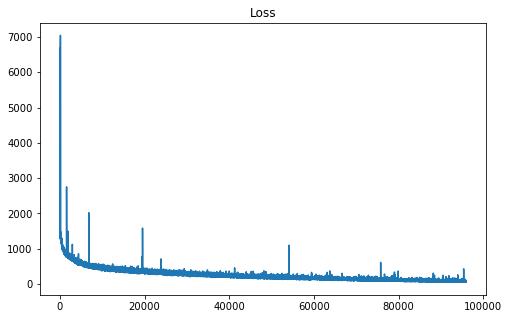

In [6]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

* train_data : shuffle 50k
* vali_data : 5k
* batch_size : 500
* Optimizer : Adam
* learning_rate : 1e-4
* accuracy_threshold : no limit
* step_limit : 45K

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
vali_filename = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'
data = np.load(filename)
vali = np.load(vali_filename)
print('The shape of data is ',data.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
Eval = []

batch_size = 500
for i in range(45000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    Loss.append(temp_loss)
    Eval.append(vali_accuracy)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %g" %(i, train_accuracy, temp_loss))



The shape of data is  (50989, 18449)
The shape of vali is  (5000, 18449)
step 0, train accuracy 0.088, train loss 5047.02
step 100, train accuracy 0.302, train loss 1865.6
step 200, train accuracy 0.35, train loss 1489.53
step 300, train accuracy 0.35, train loss 1229.81
step 400, train accuracy 0.352, train loss 1348.95
step 500, train accuracy 0.396, train loss 1147.52
step 600, train accuracy 0.384, train loss 1028.41
step 700, train accuracy 0.386, train loss 1016.24
step 800, train accuracy 0.414, train loss 963.475
step 900, train accuracy 0.412, train loss 1007.91
step 1000, train accuracy 0.468, train loss 878.78
step 1100, train accuracy 0.436, train loss 895.969
step 1200, train accuracy 0.452, train loss 908.434
step 1300, train accuracy 0.478, train loss 871.543
step 1400, train accuracy 0.462, train loss 849.294
step 1500, train accuracy 0.468, train loss 889.425
step 1600, train accuracy 0.484, train loss 842.365
step 1700, train accuracy 0.454, train loss 864.764
step 18

step 15700, train accuracy 0.762, train loss 344.358
step 15800, train accuracy 0.792, train loss 378.374
step 15900, train accuracy 0.74, train loss 378.567
step 16000, train accuracy 0.774, train loss 357.705
step 16100, train accuracy 0.768, train loss 352.892
step 16200, train accuracy 0.762, train loss 360.966
step 16300, train accuracy 0.782, train loss 327.664
step 16400, train accuracy 0.78, train loss 341.234
step 16500, train accuracy 0.786, train loss 304.097
step 16600, train accuracy 0.774, train loss 369.361
step 16700, train accuracy 0.728, train loss 389.527
step 16800, train accuracy 0.79, train loss 341.328
step 16900, train accuracy 0.772, train loss 321.474
step 17000, train accuracy 0.774, train loss 337.076
step 17100, train accuracy 0.77, train loss 341.757
step 17200, train accuracy 0.748, train loss 331.661
step 17300, train accuracy 0.756, train loss 330.794
step 17400, train accuracy 0.784, train loss 344.124
step 17500, train accuracy 0.776, train loss 314.2

step 31300, train accuracy 0.948, train loss 112.939
step 31400, train accuracy 0.946, train loss 101.689
step 31500, train accuracy 0.944, train loss 112.261
step 31600, train accuracy 0.94, train loss 120.889
step 31700, train accuracy 0.938, train loss 142.736
step 31800, train accuracy 0.942, train loss 112.938
step 31900, train accuracy 0.942, train loss 108.699


In [2]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.27      0.72      0.39        71
          1       0.53      0.46      0.49       342
          2       0.63      0.33      0.44       474
          3       0.39      0.63      0.48       119
          4       0.33      0.45      0.38       217
          5       0.55      0.43      0.48       487
          6       0.32      0.90      0.47        40
          7       0.82      0.46      0.59       586
          8       0.44      0.65      0.53       188
          9       0.28      0.51      0.36       158
         10       0.94      0.80      0.87       622
         11       0.33      0.79      0.46       125
         12       0.51      0.71      0.59       134
         13       0.79      0.55      0.65       585
         14       0.38      1.00      0.55        26
         15       0.50      0.87      0.64        91
         16       0.98      0.97      0.97       735

avg / total       0.69      0.62      0.63  

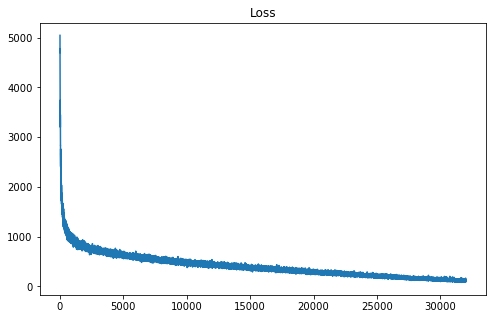

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

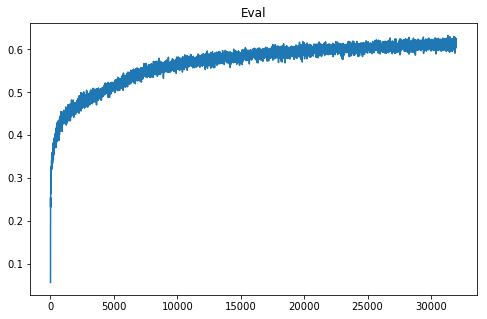

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,Eval)
plt.title('Eval')
plt.show()

* train_data : shuffle 50k
* vali_data : 5k
* batch_size : 500
* Optimizer : SGD
* learning_rate : 1e-4
* accuracy_threshold : no limit
* step_limit : 150K

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
vali_filename = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'
data = np.load(filename)
vali = np.load(vali_filename)
print('The shape of data is ',data.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1 = weight_variable([5, 5, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# second convolutional layer
w_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])

# densely connected layer
w_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout layer
w_fc2 = weight_variable([1024, 17])
b_fc2 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.GradientDescentOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 500
for i in range(150000):
    batch_x,batch_y = get_batch(data,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
    train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
    Loss.append(temp_loss)
    vali_Eval.append(vali_accuracy)
    train_Eval.append(train_accuracy)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, train loss %g" %(i, train_accuracy, temp_loss))



The shape of data is  (50989, 18449)
The shape of vali is  (5000, 18449)
step 0, train accuracy 0.13, train loss 6146.86
step 100, train accuracy 0.124, train loss 1410.16
step 200, train accuracy 0.186, train loss 1260.41
step 300, train accuracy 0.154, train loss 1256.2
step 400, train accuracy 0.256, train loss 1096.48
step 500, train accuracy 0.234, train loss 1103.16
step 600, train accuracy 0.306, train loss 1005.87
step 700, train accuracy 0.378, train loss 903.369
step 800, train accuracy 0.368, train loss 911.074
step 900, train accuracy 0.39, train loss 884.617
step 1000, train accuracy 0.438, train loss 830.192
step 1100, train accuracy 0.476, train loss 838.536
step 1200, train accuracy 0.386, train loss 856.961
step 1300, train accuracy 0.45, train loss 824.357
step 1400, train accuracy 0.462, train loss 768.298
step 1500, train accuracy 0.51, train loss 757.007
step 1600, train accuracy 0.476, train loss 771.884
step 1700, train accuracy 0.466, train loss 778.732
step 180

step 15700, train accuracy 0.758, train loss 352.635
step 15800, train accuracy 0.75, train loss 365.554
step 15900, train accuracy 0.74, train loss 360.381
step 16000, train accuracy 0.74, train loss 362.257
step 16100, train accuracy 0.756, train loss 342.398
step 16200, train accuracy 0.736, train loss 365.123
step 16300, train accuracy 0.762, train loss 347.975
step 16400, train accuracy 0.756, train loss 358.069
step 16500, train accuracy 0.752, train loss 344.733
step 16600, train accuracy 0.718, train loss 398.007
step 16700, train accuracy 0.8, train loss 320.528
step 16800, train accuracy 0.762, train loss 333.238
step 16900, train accuracy 0.762, train loss 354.692
step 17000, train accuracy 0.718, train loss 384.43
step 17100, train accuracy 0.782, train loss 316.617
step 17200, train accuracy 0.742, train loss 356.024
step 17300, train accuracy 0.726, train loss 364.693
step 17400, train accuracy 0.718, train loss 376.161
step 17500, train accuracy 0.758, train loss 356.78


step 31300, train accuracy 0.844, train loss 230.061
step 31400, train accuracy 0.844, train loss 226.085
step 31500, train accuracy 0.838, train loss 223.344
step 31600, train accuracy 0.84, train loss 227.358
step 31700, train accuracy 0.84, train loss 242.927
step 31800, train accuracy 0.854, train loss 217.547
step 31900, train accuracy 0.85, train loss 202.158
step 32000, train accuracy 0.832, train loss 246.467
step 32100, train accuracy 0.874, train loss 205.409
step 32200, train accuracy 0.852, train loss 226.606
step 32300, train accuracy 0.808, train loss 278.313
step 32400, train accuracy 0.862, train loss 196.04
step 32500, train accuracy 0.822, train loss 263.886
step 32600, train accuracy 0.848, train loss 215.685
step 32700, train accuracy 0.844, train loss 234.671
step 32800, train accuracy 0.87, train loss 197.861
step 32900, train accuracy 0.844, train loss 250.365
step 33000, train accuracy 0.824, train loss 263.739
step 33100, train accuracy 0.846, train loss 249.44

step 46900, train accuracy 0.886, train loss 172.324
step 47000, train accuracy 0.924, train loss 129.041
step 47100, train accuracy 0.904, train loss 156.882
step 47200, train accuracy 0.872, train loss 181.774
step 47300, train accuracy 0.912, train loss 139.967
step 47400, train accuracy 0.896, train loss 161.983
step 47500, train accuracy 0.892, train loss 161.11
step 47600, train accuracy 0.882, train loss 165.001
step 47700, train accuracy 0.908, train loss 145.015
step 47800, train accuracy 0.904, train loss 145.97
step 47900, train accuracy 0.902, train loss 175.424
step 48000, train accuracy 0.916, train loss 132.754
step 48100, train accuracy 0.914, train loss 136.433
step 48200, train accuracy 0.908, train loss 148.482
step 48300, train accuracy 0.918, train loss 131.942
step 48400, train accuracy 0.894, train loss 161.256
step 48500, train accuracy 0.89, train loss 162.242
step 48600, train accuracy 0.904, train loss 149.738
step 48700, train accuracy 0.888, train loss 185.

KeyboardInterrupt: 

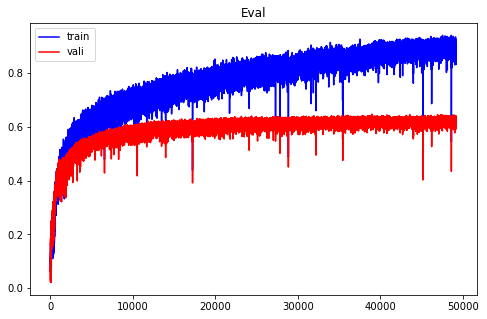

In [8]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()